In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner

## Inference on sinusoid

In [3]:
num_dim = 4
prior = utils.BoxUniform(low=torch.tensor([100,2e-3,1.,0.]), high=torch.tensor([300,6e-3,10.,2*torch.pi]))

In [4]:
time_duration = 0.01
sampling_rate = 1./4096
signal_duration = int(time_duration/sampling_rate)

In [5]:
def noise_simulator():
    return torch.randn(signal_duration) * 0.25

def signal_simulator(signal_params):
    omega = signal_params[0]
    amp = signal_params[1]
    phi = signal_params[2]
    t = torch.linspace(0,time_duration,steps=signal_duration)
    return amp*torch.cos(omega*t + phi)

def damped_sinusoid_simulator(signal_params):
    freq = signal_params[0]
    tau = signal_params[1]
    amp = signal_params[2]
    phi = signal_params[3]
    
    t = torch.linspace(0,time_duration,steps=signal_duration)
    return amp*torch.cos(2.*torch.pi*freq*t + phi)*torch.exp(-t/tau)

In [123]:
def simulator(parameter_set):
    signal = damped_sinusoid_simulator(parameter_set)
    noise = noise_simulator()
    return signal+noise

In [124]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=10000)


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 113 epochs.

In [130]:
signal_inj_params = np.array([251,4e-3,2.0,0.5])
observation = simulator(torch.from_numpy(signal_inj_params))
samples = posterior.sample((10000,), x=observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [131]:
#labels = [r"$\omega$",r"$A$",r"$\phi$"]
labels = [r"f",r"$\tau$",r"$A$",r"$\phi$"]

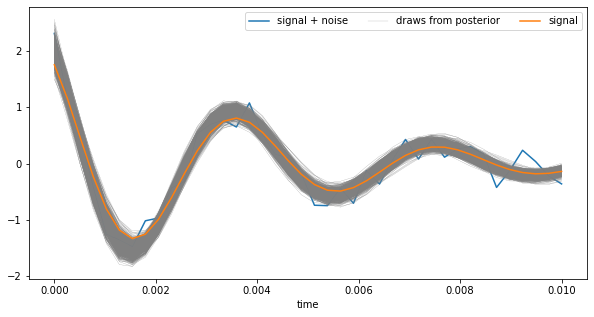

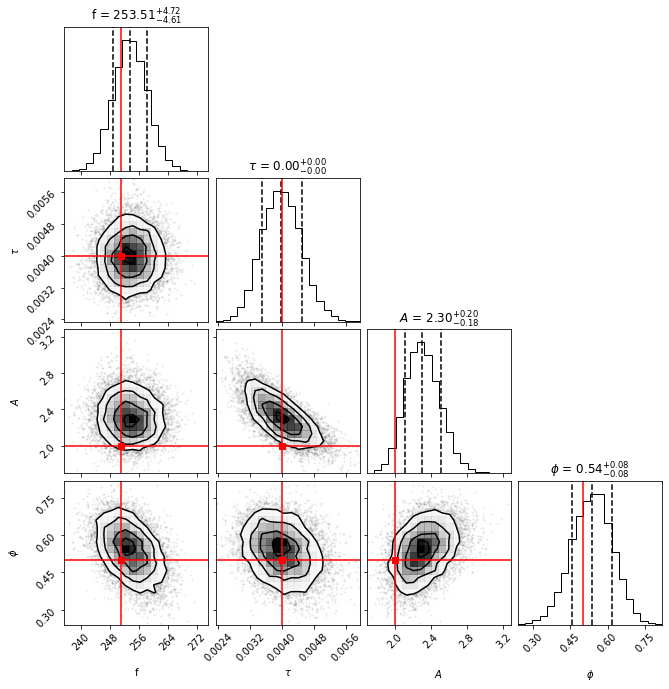

In [132]:
plt.figure(figsize=(10,5))
time = np.linspace(0,time_duration,num=signal_duration)
plt.plot(time,observation.numpy(),label='signal + noise')
for i in range(1000):
    signal_params = samples.numpy()[i]
    if i == 0:
        plt.plot(time,damped_sinusoid_simulator(signal_params),lw=0.2,c='grey',label = 'draws from posterior')
    else:
        plt.plot(time,damped_sinusoid_simulator(signal_params),lw=0.2,c='grey')
plt.plot(time,damped_sinusoid_simulator(signal_inj_params),label = 'signal')
plt.legend(loc='best',ncol=3)
plt.xlabel('time')
fig = corner.corner(
    samples.numpy(),
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=signal_inj_params,
    truth_color='red'
)